In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier

In [2]:
class Config:
    TRAIN_PATH = '../inputs/train.csv'
    TEST_PATH = '../inputs/test.csv'
    TRAIN_LABELS = '../inputs/train_labels.csv'
    SAMPLE_SUBMISSION = '../inputs/sample_submission.csv'

In [36]:
train_df = pd.read_csv(Config.TRAIN_PATH, usecols=lambda x: x not in ['fullscreen','hq','music'])
train_labels = pd.read_csv(Config.TRAIN_LABELS)

In [37]:
train_df.rename(columns={'session_id':'session'},inplace=True)

In [38]:
train_df[train_df.session==20090312431273200]

,session,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,20090312431273200,927,1267357,navigate_click,undefined,22,NaN,927.307255,-10.355929,838.0,335.0,NaN,NaN,tomap,tunic.historicalsociety.entry,NaN,13-22
877,20090312431273200,928,1268292,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,366.0,NaN,tomap,tunic.historicalsociety.entry,NaN,13-22
878,20090312431273200,929,1269474,map_click,undefined,22,NaN,457.523005,22.141338,443.0,316.0,NaN,NaN,tunic.capitol_2,tunic.historicalsociety.entry,NaN,13-22
879,20090312431273200,930,1270708,navigate_click,undefined,22,NaN,224.190321,-60.268671,404.0,337.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,13-22


In [41]:
train_labels[train_labels.session==20090312431273200]

,session_id,correct,question,session
0,20090312431273200_q1,1,1,20090312431273200
11779,20090312431273200_q2,1,2,20090312431273200
23558,20090312431273200_q3,1,3,20090312431273200
35337,20090312431273200_q4,1,4,20090312431273200
47116,20090312431273200_q5,1,5,20090312431273200
58895,20090312431273200_q6,1,6,20090312431273200
70674,20090312431273200_q7,1,7,20090312431273200
82453,20090312431273200_q8,1,8,20090312431273200
94232,20090312431273200_q9,1,9,20090312431273200
106011,20090312431273200_q10,1,10,20090312431273200


In [39]:
train_labels['question'] = train_labels['session_id'].str.split('q').str[-1].astype('int')
train_labels['session'] = train_labels['session_id'].str.split('_').str[0].astype('int64')

In [78]:
def q2l(x):
    if x <= 3:
        return '0-4'
    if x <= 12:
        return '5-12'
    return '13-22'
train_labels['level_group'] = train_labels['question'].apply(lambda x: q2l(x))

In [8]:
train_df[(train_df.level_group=='5-12')]['fqid'].value_counts()

worker           724192
archivist        563259
gramps           227448
toentry          144158
journals         135771
                  ...  
outtolunch         2997
plaque             1118
block_badge         854
block_badge_2       508
block_1              25
Name: fqid, Length: 62, dtype: int64

In [9]:
train_df[(train_df.level_group=='13-22')]['fqid'].value_counts()

wells                            353539
confrontation                    348723
crane_ranger                     251943
seescratches                     146223
groupconvo_flag                  136133
                                  ...  
businesscards.card_bingo.next       261
reader.paper0.prev                  133
reader.paper2.prev                   79
reader.paper1.prev                   65
fox                                  44
Name: fqid, Length: 66, dtype: int64

In [10]:
event_features =  ['checkpoint_click','cutscene_click', 'person_click', 'navigate_click',
                   'observation_click', 'notification_click', 'object_click',
                   'object_hover', 'map_hover', 'map_click', 'notebook_click']
name_features = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
room_features = ['historicalsociety',
          'kohlcenter',
          'capitol_0',
          'humanecology',
          'drycleaner',
          'library',
          'capitol_1',
          'wildlife',
          'flaghouse','capitol_2']
room_fqid_features = ['tunic.historicalsociety.closet',
       'tunic.historicalsociety.basement',
       'tunic.historicalsociety.entry',
       'tunic.historicalsociety.collection',
       'tunic.historicalsociety.stacks', 'tunic.kohlcenter.halloffame',
       'tunic.capitol_0.hall', 'tunic.historicalsociety.closet_dirty',
       'tunic.historicalsociety.frontdesk',
       'tunic.humanecology.frontdesk', 'tunic.drycleaner.frontdesk',
       'tunic.library.frontdesk', 'tunic.library.microfiche',
       'tunic.capitol_1.hall', 'tunic.historicalsociety.cage',
       'tunic.historicalsociety.collection_flag', 'tunic.wildlife.center',
       'tunic.flaghouse.entry', 'tunic.capitol_2.hall']
num_features = [ 
        'page', 
        'room_coor_x', 
        'room_coor_y', 
        'screen_coor_x', 
        'screen_coor_y', 
        'hover_duration']
def groupby_apply(g):
    res = {}
    fqid_dict = Counter(g['fqid'].values)
    for col in ['groupconvo','gramps', 'cs', 'plaque', 'toentry','worker','archivist', 'journals', 'wells', 'confrontation', 'crane_ranger', 'flag_girl']:
        res[f'{col}_sum'] = fqid_dict.get(col,0)
    res['text_fqid'] = pd.isnull(g['text_fqid']).sum()
    event_name_dict = Counter(g['event_name'].values)
    event_sequence = g['event_name'].values[1:]
    room_event_dict = Counter(g['room_event'].values)
    room_sequence = g['main_room'].values[1:]
    for col in event_features:
        res[f'{col}_sum'] = event_name_dict.get(col, 0)
        for col2 in room_features:
            res[f'{col}_{col2}_sum'] = room_event_dict.get(f'{col}_{col2}',0)
    room_dict = Counter(g['main_room'].values)
    for col in room_features:
        res[f'{col}_sum'] = room_dict.get(col, 0)
    room_fqid_dict = Counter(g['room_fqid'].values)
    for col in room_fqid_features:
        res[f'{col}_sum'] = room_fqid_dict.get(col, 0)
    for col in num_features:
        res[f'{col}_mean'] = np.mean(g[col])
        res[f'{col}_max'] = np.max(g[col])
        res[f'{col}_min'] = np.min(g[col])
        res[f'{col}_std'] = np.std(g[col])

    elapsed_time_diff = np.diff(g['elapsed_time'])
    res['elapsed_time_diff_mean'] = np.mean(elapsed_time_diff)
    res['elapsed_time_diff_std'] = np.std(elapsed_time_diff)
    res['elapsed_time_diff_max'] = np.max(elapsed_time_diff)
    res['elapsed_time_diff_min'] = np.min(elapsed_time_diff)
    res['duration'] = g['elapsed_time'].values[-1] - g['elapsed_time'].values[0]
    res['elapsed_time_diff_positive'] = len(elapsed_time_diff[elapsed_time_diff>0])
    for col in event_features:
        elapsed_time_diff_event = elapsed_time_diff[event_sequence==col]
        if len(elapsed_time_diff_event) > 0 :
            res[f'elapsed_time_diff_{col}_mean'] = np.mean(elapsed_time_diff_event)
            res[f'elapsed_time_diff_{col}_max'] = np.max(elapsed_time_diff_event)
            res[f'elapsed_time_diff_{col}_min'] = np.min(elapsed_time_diff_event)
        else:
            res[f'elapsed_time_diff_{col}_mean'] = 0
            res[f'elapsed_time_diff_{col}_max'] = 0
            res[f'elapsed_time_diff_{col}_min'] = 0
    for col in room_features:
        elapsed_time_diff_room = elapsed_time_diff[room_sequence==col]
        if len(elapsed_time_diff_room) > 0 :
            res[f'elapsed_time_diff_{col}_mean'] = np.mean(elapsed_time_diff_room)
            res[f'elapsed_time_diff_{col}_max'] = np.max(elapsed_time_diff_room)
            res[f'elapsed_time_diff_{col}_min'] = np.min(elapsed_time_diff_room)
        else:
            res[f'elapsed_time_diff_{col}_mean'] = 0
            res[f'elapsed_time_diff_{col}_max'] = 0
            res[f'elapsed_time_diff_{col}_min'] = 0
    res['object_per_sum_navigate_object'] = res['object_click_sum'] / (res['object_click_sum']+res['navigate_click_sum']+1)
    res['person_per_sum_navigate_object'] = res['person_click_sum'] / (res['person_click_sum']+res['navigate_click_sum']+1)
    res['object_per_sum_person_object'] = res['object_click_sum'] / (res['object_click_sum']+res['person_click_sum']+1)
    return pd.Series(res)

In [11]:
1000*60*2

120000

In [16]:
def feature_engineering(df, meta):
    df['main_room'] = df['room_fqid'].str.split('.').str[1]
    df['room_event'] =  df['event_name']+'_' + df['main_room']
    X = df.groupby(['session','level_group']).apply(groupby_apply).reset_index()
    X = meta.merge(X,how='left', on=['session','level_group'])
    X['question'] = X['question'].astype('category')
    X['level_group'] = X['level_group'].astype('category')
    for i in range(1,19):
        X[f'q{i}'] = X['question'] == i
    for i in ['0-4','5-12','13-22']:
        X[i] =  X['level_group'] == i
    return X

In [17]:
%%time
X = feature_engineering(train_df, train_labels)

CPU times: total: 1min 49s
Wall time: 1min 55s


In [18]:
FEATURES = X.columns[5:]
len(FEATURES)

280

In [19]:
n_splits=5
gkf = GroupKFold(n_splits=n_splits)
oof = np.zeros(X.shape[0])
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, valid_index) in enumerate(gkf.split(X, groups=X['session'])):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)

    xgb_params = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.01,
        'max_depth': 5,
        'n_estimators': 3000,
        'early_stopping_rounds': 50,
        'subsample':0.8,
        'colsample_bytree': 0.8,
        'seed':42,
        'use_label_encoder' : False}

    X_train = X.iloc[train_index][FEATURES]
    X_valid = X.iloc[valid_index][FEATURES]
    y_train = X.iloc[train_index]['correct'].values
    y_valid = X.iloc[valid_index]['correct'].values
        # TRAIN MODEL
    clf =  XGBClassifier(**xgb_params)
    clf.fit(X_train.astype('float32'), y_train,
            eval_set=[(X_train.astype('float32'), y_train), (X_valid.astype('float32'),y_valid)],
            verbose=100)
    print(f'({clf.best_ntree_limit}), ',end='')

        # SAVE MODEL, PREDICT VALID OOF
    models[i] = clf
    oof[valid_index] = clf.predict_proba(X_valid)[:,1]

    print()

#########################
### Fold 1
#########################


C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[0]	validation_0-logloss:0.69040	validation_1-logloss:0.69039
[100]	validation_0-logloss:0.55815	validation_1-logloss:0.55769
[200]	validation_0-logloss:0.52367	validation_1-logloss:0.52347
[300]	validation_0-logloss:0.51028	validation_1-logloss:0.51080
[400]	validation_0-logloss:0.50224	validation_1-logloss:0.50407
[500]	validation_0-logloss:0.49663	validation_1-logloss:0.49997
[600]	validation_0-logloss:0.49227	validation_1-logloss:0.49723
[700]	validation_0-logloss:0.48874	validation_1-logloss:0.49539
[800]	validation_0-logloss:0.48566	validation_1-logloss:0.49409
[900]	validation_0-logloss:0.48285	validation_1-logloss:0.49311
[1000]	validation_0-logloss:0.48034	validation_1-logloss:0.49233
[1100]	validation_0-logloss:0.47811	validation_1-logloss:0.49179
[1200]	validation_0-logloss:0.47603	validation_1-logloss:0.49135
[1300]	validation_0-logloss:0.47425	validation_1-logloss:0.49107
[1400]	validation_0-logloss:0.47253	validation_1-logloss:0.49084
[1500]	validation_0-logloss:0.47090	v

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.head(100)
    #Define size of bar plot
    plt.figure(figsize=(20,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

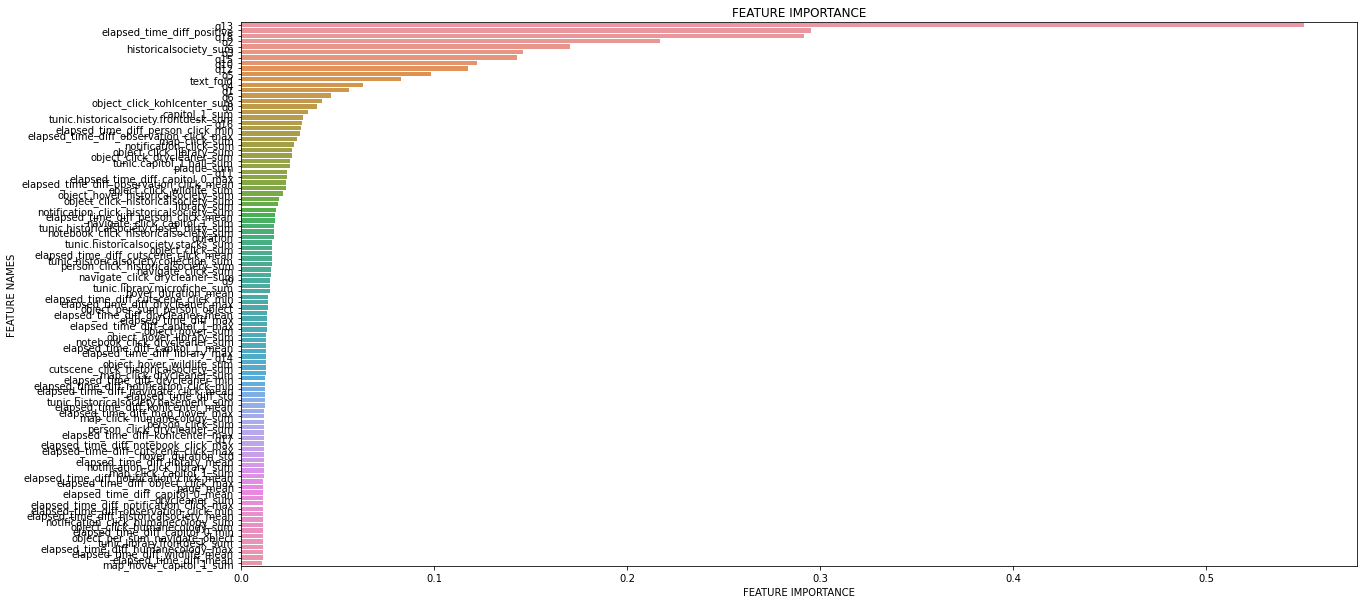

In [26]:
feat_imp = {}
for k, v in models.items():
    for x, y in zip(v.feature_importances_, v.feature_names_in_):
        if y not in feat_imp:
            feat_imp[y] = x
        else:
            feat_imp[y]+=x
plot_feature_importance(list(feat_imp.values()),list(feat_imp.keys()),'')

In [29]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.38,0.92,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof>threshold).astype('int')
    m = f1_score(X['correct'], preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 

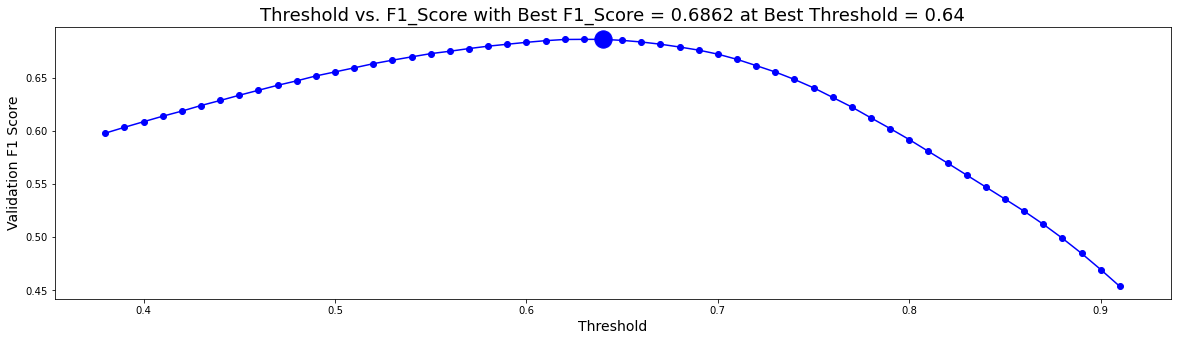

In [30]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.4f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [31]:
xgb_params = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.01,
        'max_depth': 5,
        'n_estimators': 3000,
        'subsample':0.8,
        'colsample_bytree': 0.8,
        'tree_method': 'gpu_hist',
        'seed':42,
        'use_label_encoder' : False}

In [32]:
clf =  XGBClassifier(**xgb_params)

C:\Users\PC1\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [137]:
clf.fit(X[FEATURES],X['correct'])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=3000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [140]:
clf.save_model('student-performance.json')

In [142]:
FEATURES.values

array(['text_fqid', 'checkpoint_click_sum',
       'checkpoint_click_historicalsociety_sum',
       'checkpoint_click_kohlcenter_sum',
       'checkpoint_click_capitol_0_sum',
       'checkpoint_click_humanecology_sum',
       'checkpoint_click_drycleaner_sum', 'checkpoint_click_library_sum',
       'checkpoint_click_capitol_1_sum', 'checkpoint_click_wildlife_sum',
       'checkpoint_click_flaghouse_sum', 'checkpoint_click_capitol_2_sum',
       'cutscene_click_sum', 'cutscene_click_historicalsociety_sum',
       'cutscene_click_kohlcenter_sum', 'cutscene_click_capitol_0_sum',
       'cutscene_click_humanecology_sum', 'cutscene_click_drycleaner_sum',
       'cutscene_click_library_sum', 'cutscene_click_capitol_1_sum',
       'cutscene_click_wildlife_sum', 'cutscene_click_flaghouse_sum',
       'cutscene_click_capitol_2_sum', 'person_click_sum',
       'person_click_historicalsociety_sum',
       'person_click_kohlcenter_sum', 'person_click_capitol_0_sum',
       'person_click_humanecol

In [76]:
train_df.session.unique()

array([20090312431273200, 20090312433251036, 20090314121766812, ...,
       22100217104993650, 22100219442786200, 22100221145014656],
      dtype=int64)

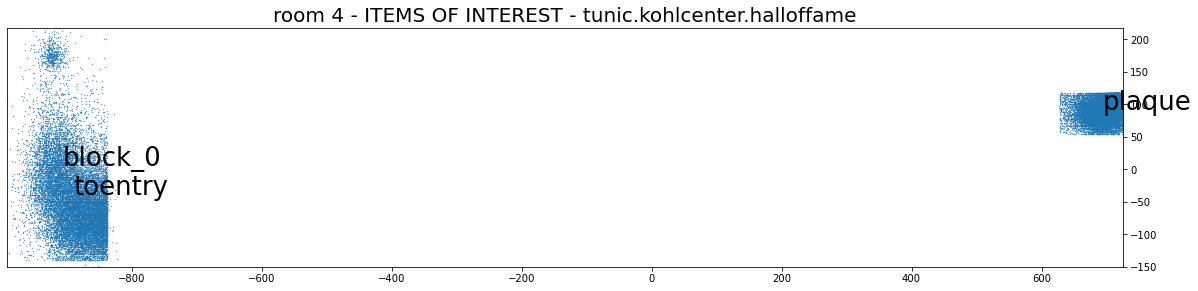

In [63]:
df = train_df.loc[(train_df.event_name=='navigate_click')
               &(train_df.room_fqid=='tunic.kohlcenter.halloffame')&(train_df.fqid.notna())&(train_df.level_group=='0-4')]
x_min,y_min = df[['room_coor_x','room_coor_y']].min().values
x_max,y_max = df[['room_coor_x','room_coor_y']].max().values
ITEMS = df.fqid.unique()
plt.figure(figsize=(20,20))
plt.scatter(df.room_coor_x,df.room_coor_y,s=0.1)
for i in ITEMS:
    mns = df.loc[df.fqid==i,['room_coor_x','room_coor_y']].mean().values
    plt.text(mns[0],mns[1],i,fontsize=26)
plt.xlim((x_min,x_max))
plt.ylim((y_min,y_max))
plt.gca().set_aspect('equal')
plt.title(f'room {3+1} - ITEMS OF INTEREST - {"tunic.kohlcenter.halloffame"}',size=20)
plt.gca().yaxis.tick_right()
plt.show()

ValueError: Axis limits cannot be NaN or Inf

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


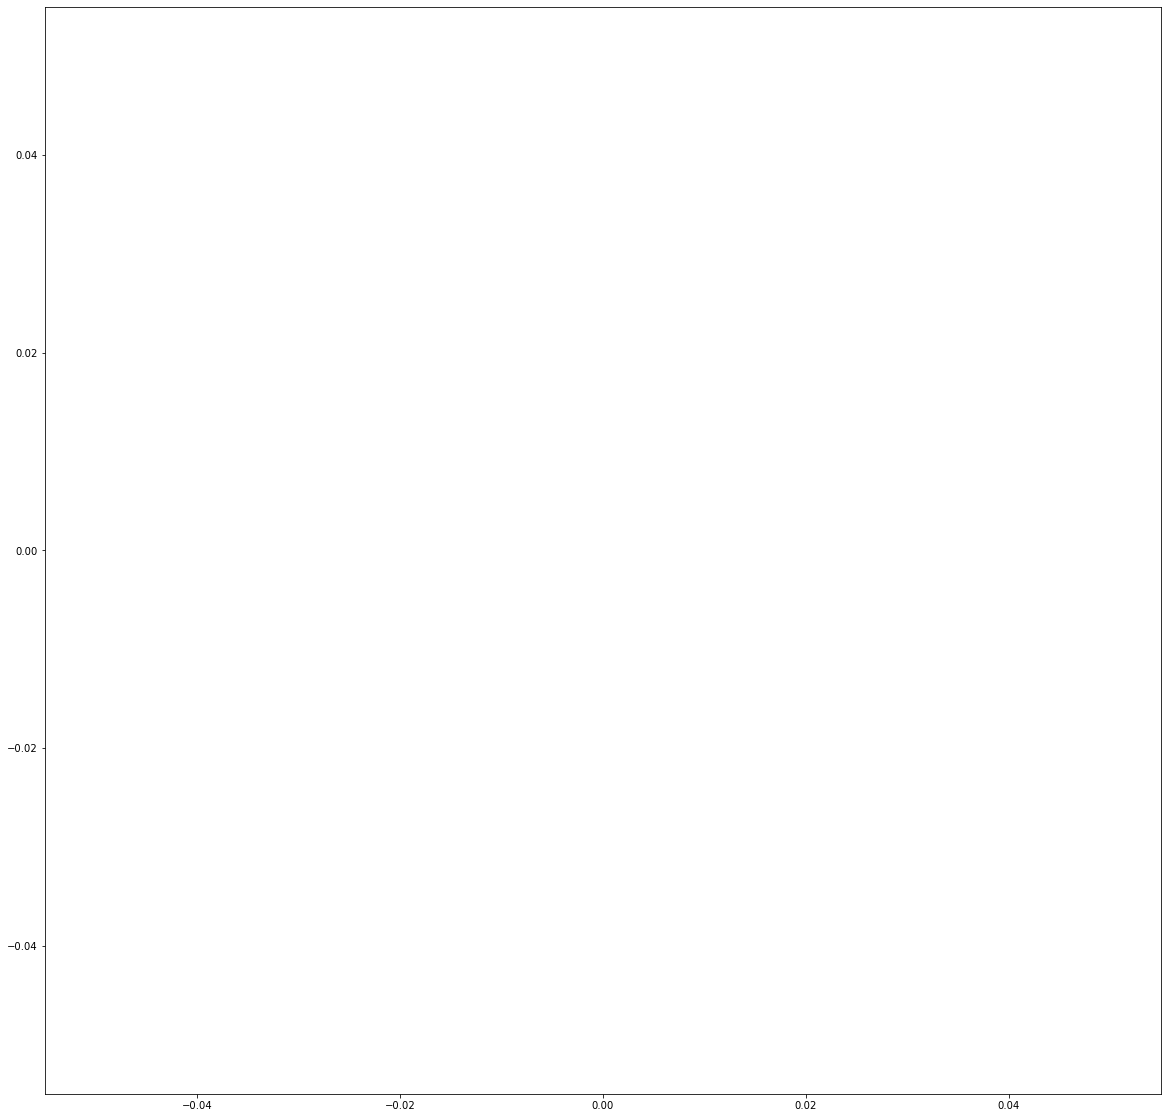

In [71]:
df = train_df.loc[(train_df.event_name=='object_hover')
               &(train_df.room_fqid=='tunic.kohlcenter.halloffame')&(train_df.fqid.notna())&(train_df.level_group=='0-4')]
x_min,y_min = df[['room_coor_x','room_coor_y']].min().values
x_max,y_max = df[['room_coor_x','room_coor_y']].max().values
ITEMS = df.fqid.unique()
plt.figure(figsize=(20,20))
plt.scatter(df.room_coor_x,df.room_coor_y,s=0.1)
for i in ITEMS:
    mns = df.loc[df.fqid==i,['room_coor_x','room_coor_y']].mean().values
    plt.text(mns[0],mns[1],i,fontsize=26)
plt.xlim((x_min,x_max))
plt.ylim((y_min,y_max))
plt.gca().set_aspect('equal')
plt.title(f'room {3+1} - ITEMS OF INTEREST - {"tunic.kohlcenter.halloffame"}',size=20)
plt.gca().yaxis.tick_right()
plt.show()

In [85]:
bla = train_labels[train_labels.level_group=='0-4'].merge(df[['session','hover_duration','level_group']],on=['session','level_group'],how='left')

In [113]:
data = bla[bla.question==1].fillna(-999)

<AxesSubplot:xlabel='correct', ylabel='hover_duration'>

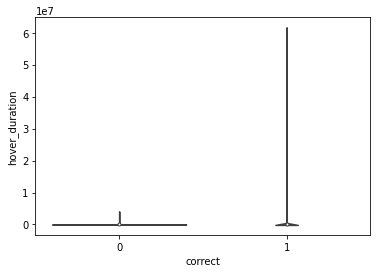

In [114]:
sns.violinplot(x='correct', y='hover_duration', data=bla[bla.question==1])

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [116]:
logreg = LogisticRegression(class_weight='imbalanced')

In [117]:
X_train, X_valid, y_train, y_valid = train_test_split(data[['hover_duration']], data['correct'], test_size=0.2, random_state=42)

In [118]:
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='imbalanced')

In [125]:
pred_prob = logreg.predict_proba(X_valid)[:,1]

In [126]:
from sklearn.metrics import f1_score,classification_report

In [127]:
for threshold in np.arange(0.4,0.8,0.01):
    print(threshold)
    pred = pred_prob>threshold
    print(classification_report(y_valid, pred))

0.4
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1482
           1       0.71      1.00      0.83      3565

    accuracy                           0.71      5047
   macro avg       0.35      0.50      0.41      5047
weighted avg       0.50      0.71      0.58      5047

0.41000000000000003
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1482
           1       0.71      1.00      0.83      3565

    accuracy                           0.71      5047
   macro avg       0.35      0.50      0.41      5047
weighted avg       0.50      0.71      0.58      5047

0.42000000000000004
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1482
           1       0.71      1.00      0.83      3565

    accuracy                           0.71      5047
   macro avg       0.35      0.50      0.41      5047
weighted avg       0.50      0

D:\Vendors\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Vendors\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Vendors\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Vendors\Anaconda3\lib\site-packages\sklearn\metrics\_classificat